In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# 폐 영역분할

다음의 2019 대한의료인공지능학회 Summer School에서 진행한 AI hands-on의 자료에서 코드르 가져와서 수정함.

https://github.com/mi2rl/ai_handson/blob/master/KoSAIM_Summer_School_2019_Handson_03_Segmentation.ipynb


## 폐 데이터 다운로드

다음에서 다운받은 데이터

https://www.kaggle.com/nikhilpandey360/lung-segmentation-from-chest-x-ray-dataset

In [ ]:
!rm -rf Lung_Segmentation.zip
!wget https://github.com/dhrim/mnd_2020/raw/master/material/deep_learning/Lung_Segmentation.zip

--2020-03-13 14:27:14--  https://github.com/dhrim/mnd_2020/raw/master/material/deep_learning/Lung_Segmentation.zip
Resolving github.com (github.com)... 13.229.188.59
Connecting to github.com (github.com)|13.229.188.59|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dhrim/mnd_2020/master/material/deep_learning/Lung_Segmentation.zip [following]
--2020-03-13 14:27:15--  https://raw.githubusercontent.com/dhrim/mnd_2020/master/material/deep_learning/Lung_Segmentation.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37648324 (36M) [application/zip]
Saving to: ‘Lung_Segmentation.zip’

Lung_Segmentation.z 100%[===================>]  35.90M  --.-KB/s    in 0.1s    

2020-03-13 14:27:15 (297 MB/s) - ‘Lung_

In [ ]:
!rm -rf Lung_Segmentation
!unzip Lung_Segmentation.zip

Archive:  Lung_Segmentation.zip
   creating: Lung_Segmentation/
   creating: Lung_Segmentation/image/
  inflating: Lung_Segmentation/image/CHNCXR_0001_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0002_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0003_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0004_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0005_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0006_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0007_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0008_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0009_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0010_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0011_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0012_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0013_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0014_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0015_0.png  
  inflating: Lung_Segmentation/image/CHNCXR

## 풀린 데이터 파일 구조

```
Lung_segmentaiton/
  image/
    CHNCXR_0001_0.png
    CHNCXR_0002_0.png
    ...
  label/
    CHNCXR_0001_0.png
    CHNCXR_0002_0.png
    ...
```

## 파일 보기

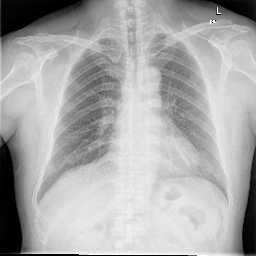

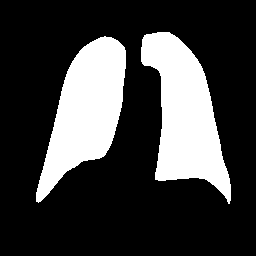

In [ ]:
from IPython.display import Image, display

display(Image('./Lung_Segmentation/image/CHNCXR_0001_0.png'))
display(Image('./Lung_Segmentation/label/CHNCXR_0001_0.png'))


## 데이터 로딩

In [ ]:
import numpy as np
import os

from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

data_path = "./Lung_Segmentation"

files = os.listdir(os.path.join(data_path, 'image'))
file_headers = []  #python list
for f in files:
    f1 = os.path.splitext(f)[0]
    file_headers.append(f1)

# file_headers = ['CHNCXR_0402_1', 'CHNCXR_0461_1', 'CHNCXR_0422_1', ... ]    
#print(file_headers)

raw_x = np.zeros((len(file_headers), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
raw_y = np.zeros((len(file_headers), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

count = 0
for fh in file_headers:
    # fh = "CHNCXR_0402_1"

    # f1 = "./Lung_Segmentation/image/CHNCXR_0402_1.png"
    f1 = os.path.join(data_path, 'image', '{}.png'.format(fh))
    # l1 = "./Lung_Segmentation/label/CHNCXR_0402_1.png"
    l1 = os.path.join(data_path, 'label', '{}.png'.format(fh))
    
    img = imread(f1)[:,:,:IMG_CHANNELS]
    # img.shape = (256, 256, 3)

    mask = imread(l1)
    # mask.shape = (256, 256)

    mask = np.expand_dims(mask, axis=-1)
    # mask.shape = (256, 256, 1)

    raw_x[count] = img
    raw_y[count] = mask
    
    count += 1


## 원시 데이터 보기

In [ ]:
print(raw_x[0])
print(raw_y[0])

[[[156 156 156]
  [154 154 154]
  [144 144 144]
  ...
  [108 108 108]
  [111 111 111]
  [114 114 114]]

 [[ 91  91  91]
  [ 85  85  85]
  [ 91  91  91]
  ...
  [ 72  72  72]
  [ 68  68  68]
  [ 64  64  64]]

 [[ 53  53  53]
  [ 55  55  55]
  [ 57  57  57]
  ...
  [ 47  47  47]
  [ 46  46  46]
  [ 42  42  42]]

 ...

 [[ 13  13  13]
  [ 14  14  14]
  [ 15  15  15]
  ...
  [ 15  15  15]
  [ 22  22  22]
  [ 15  15  15]]

 [[ 13  13  13]
  [ 14  14  14]
  [ 16  16  16]
  ...
  [246 246 246]
  [253 253 253]
  [255 255 255]]

 [[ 13  13  13]
  [ 15  15  15]
  [ 15  15  15]
  ...
  [ 60  60  60]
  [255 255 255]
  [255 255 255]]]
[[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 ...

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [F

## 데이터 정규화

In [ ]:
x_all = raw_x.astype('float32') / 255.
y_all = raw_y

## 데이터 나누기

In [ ]:
split_index = int(x_all.shape[0]*0.8)
train_x, test_x = x_all[:split_index], x_all[split_index:]
train_y, test_y = y_all[:split_index], y_all[split_index:]

In [ ]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(452, 256, 256, 3)
(452, 256, 256, 1)
(114, 256, 256, 3)
(114, 256, 256, 1)


train


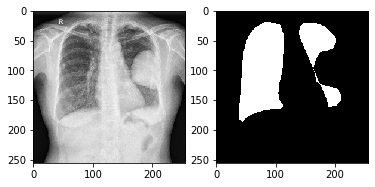

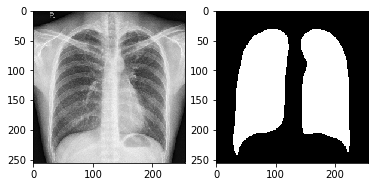

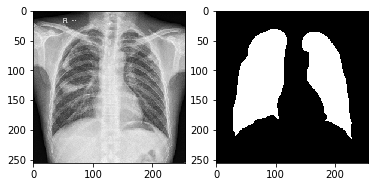

test


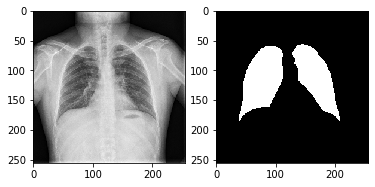

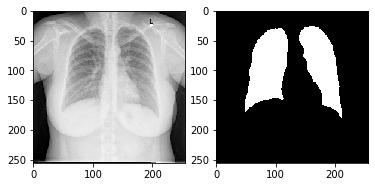

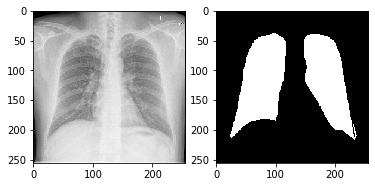

In [ ]:
import matplotlib.pyplot as plt

def plotTrainData(x, y, set_type):
    print(set_type)  
    for i in range(3):
        ix = np.random.randint(0, len(x))
        plt.subplot(1,2,1)
        plt.imshow(x[ix])
        
        plt.subplot(1,2,2)
        plt.imshow(np.squeeze(y[ix]), 'gray') # np.squeeze()는 (256,26,1)을 (256,256)으로 변환
        plt.show()
        
plotTrainData(train_x, train_y, 'train')
plotTrainData(test_x, test_y, 'test')

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    
    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
# 모델 생성
model = unet()

# 모델 컴파일
# sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) # TODO : remove
model.compile(loss="mse", optimizer="SGD", metrics=['accuracy'])

# 학습
hist = model.fit(train_x, train_y, validation_split=0.2, epochs=20, batch_size=8, verbose=1)

# 모델 저장
model.save('unet.h5')


Train on 361 samples, validate on 91 samples
Epoch 1/20
361/361 [==============================] - 15s 43ms/sample - loss: 0.2050 - acc: 0.7038 - val_loss: 0.2421 - val_acc: 0.6691
Epoch 2/20
361/361 [==============================] - 13s 37ms/sample - loss: 0.1579 - acc: 0.7934 - val_loss: 0.2490 - val_acc: 0.6351
Epoch 3/20
361/361 [==============================] - 13s 37ms/sample - loss: 0.1305 - acc: 0.8395 - val_loss: 0.2552 - val_acc: 0.5963
Epoch 4/20
361/361 [==============================] - 13s 37ms/sample - loss: 0.1103 - acc: 0.8687 - val_loss: 0.2357 - val_acc: 0.6393
Epoch 5/20
361/361 [==============================] - 13s 37ms/sample - loss: 0.0939 - acc: 0.8912 - val_loss: 0.1838 - val_acc: 0.7471
Epoch 6/20
361/361 [==============================] - 13s 37ms/sample - loss: 0.0821 - acc: 0.9062 - val_loss: 0.1570 - val_acc: 0.7693
Epoch 7/20
361/361 [==============================] - 13s 37ms/sample - loss: 0.0737 - acc: 0.9160 - val_loss: 0.1467 - val_acc: 0.7886
Epo

## 학습시 로스와 정확도 보기

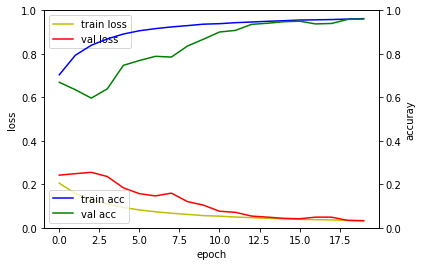

In [ ]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 1.0])

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylim([0.0, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

## 테스트 결과 보기

In [ ]:
import matplotlib.pyplot as plt

def plotPredictions(model, train_x, train_y, test_x, test_y):

    ix = np.random.randint(0, len(train_x))

    input_ = train_x[ix:ix+1]
    mask_ = train_y[ix:ix+1]

    preds_train = model.predict(input_)
    preds_train_t = (preds_train > 0.5).astype(np.uint8)

    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_train")
    plt.axis('off')
    plt.imshow(input_[0])
    plt.subplot(1,3,2)
    plt.title("Y_train")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_train_t[0][:,:,0], 'gray')
    plt.show()

    ix = np.random.randint(0, len(test_x))
    input_ = test_x[ix:ix+1]
    mask_ = test_y[ix:ix+1]
    preds_test = model.predict(input_)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)
    
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_test")
    plt.axis('off')
    plt.imshow(input_[0])
    plt.subplot(1,3,2)
    plt.title("Y_test")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_test_t[0][:,:,0], 'gray')
    plt.show()

1/1 [==============================] - 0s 17ms/sample - loss: 0.0286 - acc: 0.9670


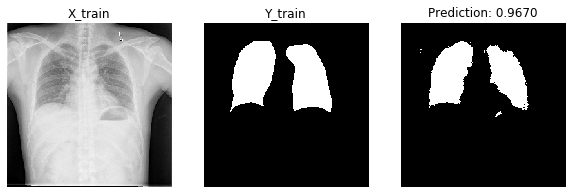

1/1 [==============================] - 0s 16ms/sample - loss: 0.0268 - acc: 0.9695


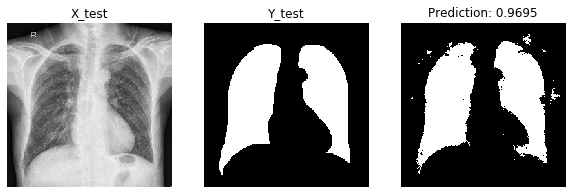

In [ ]:
plotPredictions(model, train_x, train_y, test_x, test_y)